# Social Network Analysis group project 📊

***

## Group members 👥
- Michele Turco
- Simone Filosofi
- Edoardo Cocciò
- Lorenzo Laterza

# General Introduction



The graph we have choosen is "Forrest Gump (movie) network". 

This graph is undirected and weighted.
Nodes are characters and the link represent a same-scene appearance between two characters in the movie,
and the weight gives the number of same-scene appearances.

Source: J. Kaminski et al., "Moviegalaxies - Social Networks in Movies." 


# Importing libraries  

In [3]:
import networkx as nx # this is for network analysis
import pandas as pd # this is for data analysis
import matplotlib.pyplot as plt # this is for plotting
import json # this is for reading json files

# 1) Week 1

a) Implement it in Python.

b) Draw the graph

c) Compute the number of nodes,edges, average degree and the density. Comment.

# Reading the input file

In [4]:
nodes_df = pd.read_csv('data/nodes.csv', index_col=0,sep = ',')
edges_df = pd.read_csv('data/edges.csv')
nodes_df[' viz'] = nodes_df[' viz'].apply(lambda row: row.replace("'", '"')).apply(json.loads) # replace single quotes with double quotes and convert to dict

nodes_df['size'] = nodes_df[' viz'].apply(lambda row: row['size'] * 100) # multiply by 100 to make the visualization of the nodes better
nodes_df[' _pos'] = nodes_df[' _pos'].apply(lambda row: (float(row[7:18]), float(row[20:-2]))) # convert string to tuple containing x and y coordinates


# a) Implementing the graph

In [5]:
G = nx.Graph()

links = edges_df.apply(lambda row: (row['# source'], row[' target'], row[' weight']), axis=1) 
links = list(links)  # The edges of the Graph are stored in a list of tuples containing the source, target and weight of the edge

labels = enumerate(nodes_df[' label'])
labels = dict(labels)

pos = nodes_df[' _pos'] 

colors = []
for n in range(0, len(nodes_df)):
    color = nodes_df[' viz'][n]['color']
    accepted_format = (color['r']/255, color['g']/255, color['b']/255, color['a'])
    colors.append(accepted_format)
    G.add_node(n)

G.add_weighted_edges_from(links)
nx.set_node_attributes(G, labels, name = 'label')


# b) Draw the graph

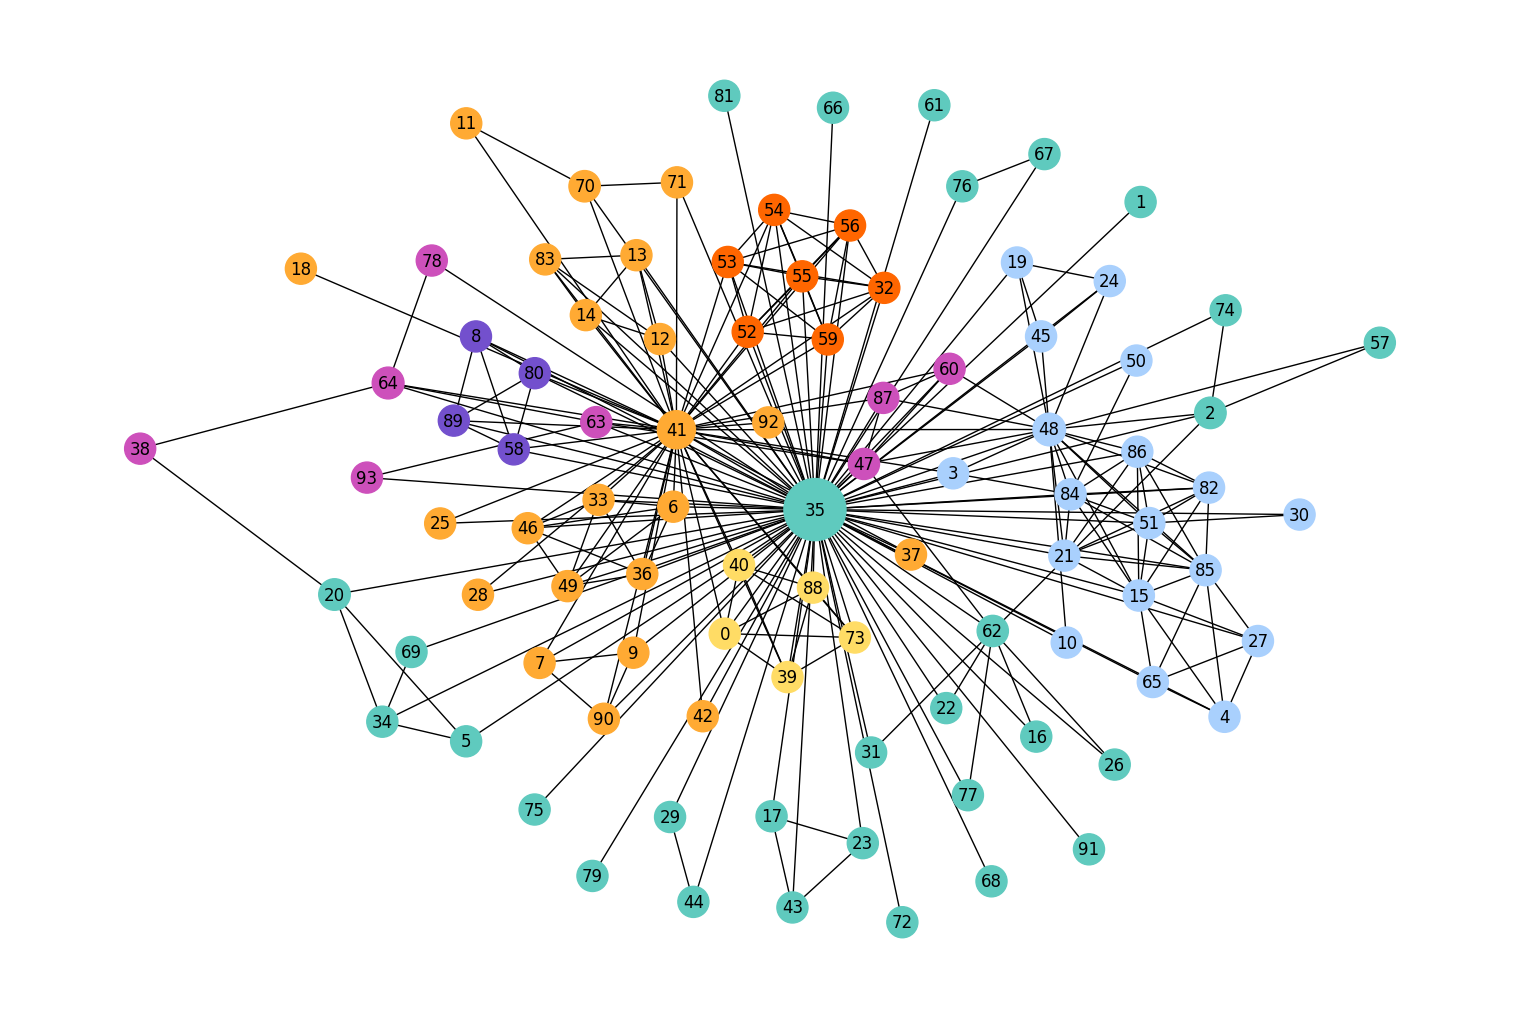

In [6]:
plt.figure(figsize=(15, 10))


nx.draw(G, node_size = nodes_df['size'], pos = pos, with_labels = True, node_color = colors)

# c) Compute:

### - Number of nodes

In the film appear 94 characters, so the number of nodes is 94.

In [7]:
N = G.number_of_nodes()
print("Number of nodes: ", N)

Number of nodes:  94


### - Number of edges

In [8]:
E = G.number_of_edges()
print("Number of edges: ", E)

Number of edges:  271


### - Average degree


In [9]:
Average_degree = 2 * E / N
print("Average degree: ", Average_degree)

Average degree:  5.76595744680851


### - Density

The density is very low (0.06199954243880119). 

It means that here are relatively few edges compared to the total number of possible edges in the graph. Not all the characters interact with each other.


In [10]:
density = Average_degree/(N - 1)
print("Density: ", density)

Density:  0.06199954243880119


# 2) Week 2

While considering the largest component of your network.

a) Compute Average clustering and Transitivity number

b) Implement a function computing the transitivity using basic function of networkx

# Checking what's the largest component of the graph
Since all nodes are connected we are considering the entire graph for the following computations. The first function is used to check if the graph is connected.

In [11]:
cc = [i for i in nx.connected_components(G)] # list of connected components
len(cc) # number of connected components

1

### Diameter

In [12]:
nx.diameter(G) # the maximum distance between two nodes iinside the graph

4

### Average Shortest Path Length

In [13]:
nx.average_shortest_path_length(G)

1.9949668268130862

# a) Average Clustering

In [14]:
nx.average_clustering(G)

0.8002425574908809

# b) Transitivity implementation using basic networkx functions

To compute the **transitivity** _t_:
$$T = \frac{3(\#triangles)}{\sum\limits_{i}\frac{K(i)(K(i)-1)}{2}}$$
where $\sum\limits_{i}\frac{K(i)(K(i)-1)}{2}$ is the number of wedges in the graph.


The first function in the following block is used to count the number of triangles in the graph. It iterates over all the nodes and for each of them it stores their neighbours. Then it checks if there are edges between the neighbours. If there are, it means that there is a triangle.  
The second function is used to compute the transitivity. It uses the number of triangles computed in the previous function and the number of wedges stored in the variable denominator.

In [15]:
def count_triangles(G):
    "Count the number of triangles in the graph without using nx.triangles "
    triangles = 0
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        for i in range(len(neighbors)):
            for j in range(i + 1, len(neighbors)):
                u, v = neighbors[i], neighbors[j]
                if (u,v) in G.edges():
                    triangles += 1
    return triangles   # Each triangle is counted 3 times (once for each node)

def transitivity(G):
# Actual number of triangles is 'triangles'/3, but the denominator semplifies with the '3' in the main formula

    triangles = count_triangles(G) # number of triangles inside the graph
    denominator = 0 # denominator of the formula

    for node in G.nodes():
        fraction = (G.degree(node) * (G.degree(node) - 1))/2 # number of wedges
        denominator += fraction

    return triangles / denominator

print(f"Transitivity results:\n---------------------------------------  \nOur implementation: {transitivity(G)} \nNetworkx: {nx.transitivity(G)}")


Transitivity results:
---------------------------------------  
Our implementation: 0.1918081918081918 
Networkx: 0.1918081918081918


# 3) Week 3

Depending on what seems more relevant in your graph, pick one of the following local notions:
- Decay centrality 
- Betweeness centrality 
- Closeness centrality 
- Clustering
- Any other notions that you invent

a) Provide a code computing the given centrality using basic functions of networkx (you are not allowed to use directly nx."what you want").

b) Discuss why you picked this measure and who is the most central in your network based on your choice.

c) Provide the cumulative distribution for this centrality and give a graphical representation of your graph (log-log, log or normal representation as you think it is more relevant).

# a) Closeness centrality 


To compute the **closeness centrality of node** _i_:
$$g_{i} = \frac{1}{\sum\limits_{i \ne j}\ell(i,j)}$$
where $\ell(i,j)$ is the distance (shortest path) between the two nodes.

To get a more relevant result we computed the **normalized closeness centrality**:
$$C_{i}^{clo} = g_{i}\cdot (N-1) = \frac{N - 1}{\sum\limits_{i \ne j}\ell(i,j)}$$  




The following block contains the functions used to compute the lenght of the shortest path between two nodes, that is needed to compute the closeness centrality.  
The first function **shortest_path** returns the shortest path between two nodes and its lenght. However, it firstly checks if there is an edge between the two nodes (and returns the path of lenght 1) and if the two nodes are the same (and returns the path of lenght 0). At each iteration, the function checks if the target node is a neighbor of the last node in the current path. If it is, the path is returned. Otherwise, the function adds to the list of path all the paths that can be obtained by adding a neighbor of the last node in the current path. If no path is found, the function returns an empty list (note that this is not the case being the graph taken into account connected).  
The second function **shortest_path_length** returns the lenght of the shortest path between two nodes. It uses the first function to get the path and then returns its lenght. The results are stored in a dictionary having the target node as a key and the length of the shortest path as value.

In [16]:
def shortest_path(graph, start, target):
    # If the starting node is equal to the target the shortest path between the two is zero
    if start == target:
        return ([], 0)
    # If there is a direct link between the two nodes the shortest path is one
    if (start, target) in graph.edges():
        return ([target], 1)
    
    
    path_list = [[start]]     # List of paths to be explored
    path_index = 0            # Index of the path to be explored
    previous_nodes = {start}  # To keep track of previously visited nodes

     
    while path_index < len(path_list):
        current_path = path_list[path_index] # Current path
        last_node = current_path[-1]         # Last node in current path
        next_nodes = graph[last_node]        # Nodes connected to last node
        # Search target node
        if target in next_nodes:
            current_path.append(target)
            return (current_path[1:], len(current_path)-1)
        # Add new paths
        for next_node in next_nodes:
            if next_node not in previous_nodes: 
                new_path = current_path[:] # Copy current path
                new_path.append(next_node) # Add next node
                path_list.append(new_path) # Add new path to path_list
                
                previous_nodes.add(next_node) # Add next node to previous_nodes
        # Continue to next path in list
        path_index += 1
    
    
    # In case no path is found
    return ([], -1)

def lenght_shortest_path(graph, start):

    spl = dict()

    for node in graph.nodes():
            spl[node] = shortest_path(G,start,node)[1]

    return spl

print(f"Shortest path results:\n---------------------------------------  \nOur implementation: {sorted(lenght_shortest_path(G, 0).items())} \nNetworkx: {sorted(nx.shortest_path_length(G, 0).items())}")
print(f"Sum of shortest path results:\n---------------------------------------  \nOur implementation: {sum(lenght_shortest_path(G, 44).values())} \nNetworkx: {sum(nx.shortest_path_length(G, 44).values())}")


Shortest path results:
---------------------------------------  
Our implementation: [(0, 0), (1, 2), (2, 2), (3, 2), (4, 2), (5, 2), (6, 2), (7, 2), (8, 2), (9, 2), (10, 2), (11, 2), (12, 2), (13, 2), (14, 2), (15, 2), (16, 2), (17, 2), (18, 2), (19, 2), (20, 2), (21, 2), (22, 2), (23, 2), (24, 2), (25, 2), (26, 2), (27, 2), (28, 2), (29, 2), (30, 2), (31, 2), (32, 2), (33, 2), (34, 2), (35, 1), (36, 2), (37, 2), (38, 3), (39, 1), (40, 1), (41, 1), (42, 2), (43, 2), (44, 2), (45, 2), (46, 2), (47, 2), (48, 2), (49, 2), (50, 2), (51, 2), (52, 2), (53, 2), (54, 2), (55, 2), (56, 2), (57, 3), (58, 2), (59, 2), (60, 2), (61, 2), (62, 2), (63, 2), (64, 2), (65, 2), (66, 2), (67, 2), (68, 2), (69, 2), (70, 2), (71, 2), (72, 2), (73, 1), (74, 2), (75, 2), (76, 2), (77, 2), (78, 2), (79, 2), (80, 2), (81, 2), (82, 2), (83, 2), (84, 2), (85, 2), (86, 2), (87, 2), (88, 1), (89, 2), (90, 2), (91, 2), (92, 2), (93, 2)] 
Networkx: [(0, 0), (1, 2), (2, 2), (3, 2), (4, 2), (5, 2), (6, 2), (7, 2), (8

# b) Discussion on the choice of picking the Closeness centrality
We chose to calculate this centrality measure because it is a relevant metric to highlight interconnectedness and prominence of different elements within our dataset, offering valuable insights about the relationships of characters. In the context of character interaction, closeness centrality helps us to identify which characters are central to the storyline and have close ties with other characters.

More specifically we chose to calculate the closeness centrality of `node 35`(Forrest) and `node 41`(Jenny) as they are the most visible nodes that also have the highest number of links (check the representation of the graph).

In [17]:
# This function trivially applies the formula of the closeness centrality using the values that we previously computed 

def normalized_closeness_centrality(graph, node):
    return (len(graph.nodes()) - 1) / sum(lenght_shortest_path(graph, node).values())

print(f"Centrality of node 35 (Forrest) is: {normalized_closeness_centrality(G, 35)}")
print(f"Centrality of node 41 (Jenny) is: {normalized_closeness_centrality(G,41)}")

Centrality of node 35 (Forrest) is: 0.9587628865979382
Centrality of node 41 (Jenny) is: 0.6595744680851063


# Interpreting the closeness centrality results 🔍

- For node 35, with a centrality of approximately **0.949**, this suggests that it is **highly central within the network**. Nodes with high centrality values like this one often have shorter average distances to all other nodes, meaning they are well-connected and can efficiently communicate or interact with a large portion of the network. As expected, this node plays a crucial role in the network's overall structure and information flow because it is the protagonist of the film: Forrest.

- On the other hand, for node 41 (which is Jenny, Forrest's wife), with a centrality of approximately **0.655**, it also holds a **relatively high** centrality value, indicating that it is important within the network, although not as central as Forrest. This node has meaningful connections and interactions within the network but is not as influential as node 35. It still plays a significant role in the network's structure and communication pathways.

# c) Cumulative distribution function

$$F(x) = P(X \ge x)$$  

The following block contains the code used to compute the cumulative (tail) distribution function of the closeness centrality. It firstly stores in a list the closness centrality for each node and it sorts them in ascending order. Then, it computes the cumulative distribution function for each value of the list by checking how many values are greater than or equal to the current one. Finally, it returns the list of values and the list of probabilities.

[1.0, 0.9893617021276596, 0.9787234042553191, 0.9680851063829787, 0.9574468085106383, 0.9574468085106383, 0.9574468085106383, 0.9574468085106383, 0.9574468085106383, 0.9574468085106383, 0.9574468085106383, 0.9574468085106383, 0.9574468085106383, 0.8617021276595744, 0.8617021276595744, 0.8617021276595744, 0.8617021276595744, 0.8617021276595744, 0.8617021276595744, 0.8617021276595744, 0.8617021276595744, 0.8617021276595744, 0.8617021276595744, 0.8617021276595744, 0.8617021276595744, 0.8617021276595744, 0.723404255319149, 0.723404255319149, 0.723404255319149, 0.723404255319149, 0.723404255319149, 0.723404255319149, 0.6595744680851063, 0.6595744680851063, 0.6595744680851063, 0.6595744680851063, 0.6595744680851063, 0.6595744680851063, 0.5957446808510638, 0.5957446808510638, 0.5957446808510638, 0.5957446808510638, 0.5957446808510638, 0.5957446808510638, 0.5957446808510638, 0.5957446808510638, 0.5957446808510638, 0.5, 0.5, 0.5, 0.5, 0.5, 0.44680851063829785, 0.44680851063829785, 0.44680851063

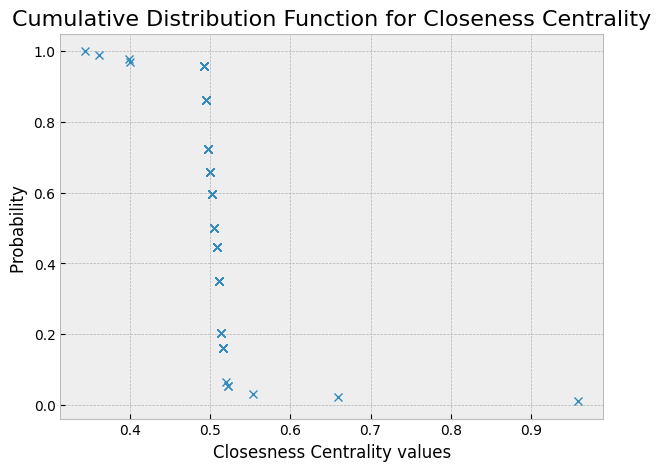

In [18]:

data_closeness_centrality = []
for node in G.nodes():
    data_closeness_centrality.append(normalized_closeness_centrality(G,node))
data_closeness_centrality.sort() 
number_of_nodes = len(data_closeness_centrality)

cdf_x = data_closeness_centrality
cdf_y = []  

for x in cdf_x: 
    y=sum(variable>=x for variable in data_closeness_centrality)/number_of_nodes # count how many elements are bigger than x and divide by the total number of elements
    cdf_y.append(y) 
print(cdf_y)

plt.figure(figsize = (7,5))
plt.style.use('bmh')
plt.title('Cumulative Distribution Function for Closeness Centrality', fontsize = 16)

plt.xlabel('Closesness Centrality values')
plt.ylabel('Probability ')
plt.plot(cdf_x,cdf_y,"x")



# Discussion on the graphical representation
- Being the dataset relatively small, we chose to represent the cumulative distribution function of the closeness centrality using a **normal scale**. This choice allows us to better visualize the distribution of the values and the probability of each value.  

# Interpreting the cdf 🔍

- The cumulative distribution function of the closeness centrality shows that **most of the nodes** have a **low/medium centrality** value: most of the nodes have indeed a centrality value between 0.2 and 0.5. This feauture could be predicted since the nodes represent characters in a film and it is reasonable to assume that most of them have a similar importance in the story, but not all of them are central to the plot and interconnected.
- On the other hand, the **few nodes** that have a **high centrality** value are **very central** to the network. This is the case of node 35 (Forrest) and node 41 (Jenny), which have a centrality value of approximately 0.949 and 0.655 respectively. This is not surprising since these nodes are the most visible ones in the graph and they have the highest number of links (check the representation of the graph).

# 4) Week 5

a) We write a function for PageRank without using any NetworkX built-in function;

b) We run it using alpha = 0.15, saving the number of iterations needed and checking that the our result is the same of the one given by the built-in function;

c) Indentify the node with the highest PageRank and compare it with the one we got from Week 3;

d) Cumulative distibution and compare it with the one from Week 3;

e) (optinal) we re-run the PageRank using alpha= 0.5, saving the total number of iterations and compare with the results of point (b).

## a) Our PageRank function

1. Initialize each node with $R_{0} = \frac{1}{N}$
2. At each iteration denoted by $t$, loop over nodes to update PageRank:
    $$R_{t}(i) = \frac{\alpha}{N} + (1 - \alpha) \sum\limits_{j \in pred(i)}\frac{R_{t - 1}(j)}{k_{out}(j)}$$
    
The formula is **iterated until convergence**, when there are no change in scores.

In [143]:
def pagerank_single_node(G, alpha, node):
    """
    This function calculates the pagerank value for a single node.

    Parameters
    ----------
    - G: graph, it is assumed to be an undirected graph as the one we are dealing with for this project.

    - alpha: a parameter for PageRank

    - node: the specific node for which we want to know its pagerank value

    Returns
    -------
    A list containing the pagerank value for the specified node and the number of iterations it took to reach the convergence.
    
    """
    # Initialize PageRank values
    N = len(G.nodes())
    initial_pagerank = 1 / N
    pagerank = {n: initial_pagerank for n in G.nodes()}

    iterations = 0 # Keep track of the number of iterations
    while True:
        new_pagerank = {}
        for n in G.nodes():
            # Calculate PageRank for the current node
            sum_rank = 0
            for neighbor in G.neighbors(n):
                sum_rank += pagerank[neighbor] / len(list(G.neighbors(neighbor)))
            new_pagerank[n] = (1 - alpha) / N + alpha * sum_rank

        iterations += 1

        # Check for convergence for the specific node
        if new_pagerank[node] == pagerank[node]:
            return [new_pagerank[node], iterations]

        pagerank = new_pagerank

In [146]:
# We want the pagerank values at convergence for each node in the graph to compare the results with the built-in function of networkx

def pagerank_all_nodes(alpha):
    pagerank_all_nodes = {}
    for node in G.nodes():
        pagerank_all_nodes[node] = pagerank_single_node(G, alpha, node)
    return pagerank_all_nodes

## b) Pagerank using $\alpha$ = 0.15

In [148]:
print(f'Our implementation result is: {pagerank_all_nodes(alpha = 0.15)}')
print(f'NetworkX built-in function result is: {nx.pagerank(G, 0.15)}')


Our implementation result is: {0: [0.010239417206402292, 16], 1: [0.009132325346609736, 16], 2: [0.010915013248065165, 17], 3: [0.009500360925601161, 16], 4: [0.010041249927890298, 17], 5: [0.009939086540012134, 16], 6: [0.010239417206402292, 16], 7: [0.00996267620082385, 16], 8: [0.010126896138200068, 16], 9: [0.00996267620082385, 16], 10: [0.009246669274320695, 16], 11: [0.009516058508406772, 15], 12: [0.010126896138200068, 16], 13: [0.010126896138200068, 16], 14: [0.010126896138200068, 16], 15: [0.011236484805595299, 17], 16: [0.009379860075802158, 17], 17: [0.010147028162899707, 16], 18: [0.009125703330641688, 17], 19: [0.009996399215481833, 16], 20: [0.010765492634203747, 17], 21: [0.010293003293142325, 17], 22: [0.009379860075802158, 17], 23: [0.010147028162899707, 16], 24: [0.009996399215481833, 16], 25: [0.009215475485762062, 16], 26: [0.009379860075802158, 17], 27: [0.010041249927890298, 17], 28: [0.009215475485762062, 16], 29: [0.009872784158497011, 16], 30: [0.00931568064420

## c) Node with the highest Pagerank

In [141]:
highest_pagerank = max(pagerank_all_nodes.items(), key = lambda x:x[1][0])
highest_pagerank

(35, [0.05326481203808891, 17])

## Considerations on the result and comparisons with Week 3  🔍

The node with the highest Pagerank is Forrest (node 35). It was also the most central node with respect to the Closeness centrality we calculated in Week 3. 

Considerations: 

# d) Cumulative distribution

[0.3723404255319149, 0.9893617021276596, 0.10638297872340426, 0.7127659574468085, 0.5212765957446809, 0.5957446808510638, 0.3723404255319149, 0.5851063829787234, 0.48936170212765956, 0.5851063829787234, 0.8404255319148937, 0.7021276595744681, 0.48936170212765956, 0.48936170212765956, 0.48936170212765956, 0.06382978723404255, 0.8085106382978723, 0.40425531914893614, 1.0, 0.5531914893617021, 0.11702127659574468, 0.26595744680851063, 0.8085106382978723, 0.40425531914893614, 0.5531914893617021, 0.8936170212765957, 0.8085106382978723, 0.5212765957446809, 0.8936170212765957, 0.6382978723404256, 0.8191489361702128, 0.8085106382978723, 0.23404255319148937, 0.3723404255319149, 0.1276595744680851, 0.010638297872340425, 0.3723404255319149, 0.8936170212765957, 0.6702127659574468, 0.3723404255319149, 0.3723404255319149, 0.02127659574468085, 0.8936170212765957, 0.40425531914893614, 0.6382978723404256, 0.5531914893617021, 0.3723404255319149, 0.13829787234042554, 0.031914893617021274, 0.37234042553191

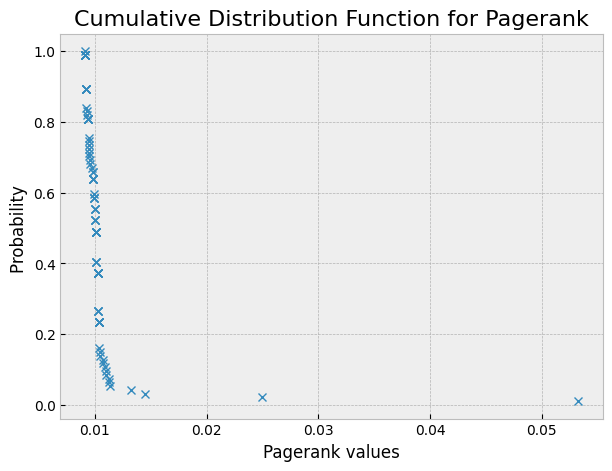

In [157]:
data_pagerank = pagerank_all_nodes(alpha = 0.15) # Create a list to store the PageRank values
pagerank_values = []


for value in data_pagerank.values():
    pagerank_values.append(value[0])

cdf_x = pagerank_values.copy()  # Create a list containing the PageRank values
cdf_y = []          # Create a list to store the cumulative distribution function values

for x in cdf_x:   # For each PageRank value
    y=sum(variable>=x for variable in pagerank_values)/number_of_nodes # Count how many elements are bigger than x and divide by the total number of elements
    cdf_y.append(y)  # Add the value to the list
print(cdf_y) 

plt.figure(figsize = (7,5))     # Create a new figure
plt.style.use('bmh')           # Use the 'bmh' style
plt.title('Cumulative Distribution Function for Pagerank', fontsize = 16) # Set the title

plt.xlabel('Pagerank values') # Set the label of the x axis
plt.ylabel('Probability ') # Set the label of the y axis
plt.plot(cdf_x,cdf_y,"x") # Plot the cumulative distribution function

## e) Re-run the PageRank using α = 0.5

We call again 'OurPageRank' function but giving a different value to alpha (0.5) to compare the new result with the previous one.

In [153]:
print(f'Our implementation result is: {pagerank_all_nodes(alpha = 0.5)}')
print(f'NetworkX built-in function result is: {nx.pagerank(G, 0.5)}')

Our implementation result is: {0: [0.009880437474608449, 36], 1: [0.0060155110396139765, 32], 2: [0.01119375824382006, 35], 3: [0.007831356477306917, 35], 4: [0.009018632284927485, 37], 5: [0.008688803958788459, 36], 6: [0.009880437474608449, 36], 7: [0.008782611088540844, 35], 8: [0.009409940452008046, 36], 9: [0.008782611088540844, 35], 10: [0.006605921359558117, 35], 11: [0.007098169895034007, 36], 12: [0.009409940452008048, 35], 13: [0.009409940452008048, 35], 14: [0.009409940452008048, 35], 15: [0.013193342671608141, 37], 16: [0.007062392437752834, 35], 17: [0.009023266559420963, 35], 18: [0.005890596212961869, 36], 19: [0.00880789514607749, 37], 20: [0.010743311845443079, 35], 21: [0.010435247416747204, 38], 22: [0.007062392437752834, 35], 23: [0.009023266559420963, 35], 24: [0.00880789514607749, 37], 25: [0.006586958316405633, 34], 26: [0.007062392437752834, 35], 27: [0.009018632284927485, 37], 28: [0.006586958316405633, 34], 29: [0.008020681386151966, 35], 30: [0.00668704854042

## Cosiderations on the new Pagerank   🔍

Considerations on the different results:

Considerations on the new number of iterations:

# 5) Week 6

a) Treat your graph as undirected and unweighted. Delete loops and work on the resulting largest connected component.

b) Implement the following three techniques for community detection:
1) Bridge removal (pick the partition with the highest modularity),
2) Modularity optimization
3) Label propagation.

In this case, you are allowed to use built-in functions from NetworkX.

c) Compare the results of each technique in terms of: 
1) number of detected clusters
2) cluster size distribution
3) computational time
4) modularity
5) other aspects you consider relevant, if any.
 Results should be presented in a table.

d) Give an interpretation to the differences and similarities between the three resulting partitions, and discuss which one you think is the best and why.

e) Provide a visualization for the partition you decided to be the best using Gephi.

 f) Optional: for each pair of partitions compute the NMI between them and discuss.


# a) 

## Is the graph connected?

In [28]:
is_connected = nx.is_connected(G) # Check if the graph is connected
print(is_connected)

True


The print command returned 'True' so our graph is connected.

## Is there any self loop in the graph?

In [29]:
has_self_loops = any([u == v for u, v in G.edges]) # Check if the graph has self loops
print(has_self_loops)

False


The print command returned 'False', so our graph has not self loops.

# b.1) Bridge removal

In [30]:
# find the bridges
def edges_betweeness(G):
    for edge in G.edges: # For each edge in the graph
        G.edges[edge]['betweenness'] = 0 # Initialize the betweenness of each edge to 0 
    for node in G.nodes: # For each node in the graph 
        for path in nx.all_simple_paths(G, source=node, target=node): # For each path (without repetition) between the node and itself 
            for i in range(len(path) - 1): # For each edge in the path 
                G.edges[(path[i], path[i+1])]['betweenness'] += 1 # Increment the betweenness of the edge by 1
    for edge in G.edges: # For each edge in the graph
        G.edges[edge]['betweenness'] /= 2 # Divide the betweenness by 2 to avoid counting each edge twice
    return G 


In [31]:
print(edges_betweeness(G).edges(data=True)) # Print the edges with their betweenness [(u1, v1, {'betweenness': score1}), (u2, v2, {'weight':score1, 'betweenness': score2}), ...]

[(0, 41, {'weight': 1, 'betweenness': 0.0}), (0, 73, {'weight': 1, 'betweenness': 0.0}), (0, 35, {'weight': 1, 'betweenness': 0.0}), (0, 39, {'weight': 1, 'betweenness': 0.0}), (0, 40, {'weight': 1, 'betweenness': 0.0}), (0, 88, {'weight': 1, 'betweenness': 0.0}), (1, 35, {'weight': 1, 'betweenness': 0.0}), (2, 35, {'weight': 3, 'betweenness': 0.0}), (2, 48, {'weight': 1, 'betweenness': 0.0}), (2, 57, {'weight': 1, 'betweenness': 0.0}), (2, 62, {'weight': 1, 'betweenness': 0.0}), (2, 74, {'weight': 1, 'betweenness': 0.0}), (3, 35, {'weight': 2, 'betweenness': 0.0}), (3, 41, {'weight': 1, 'betweenness': 0.0}), (3, 48, {'weight': 1, 'betweenness': 0.0}), (3, 84, {'weight': 1, 'betweenness': 0.0}), (4, 15, {'weight': 1, 'betweenness': 0.0}), (4, 65, {'weight': 1, 'betweenness': 0.0}), (4, 85, {'weight': 1, 'betweenness': 0.0}), (4, 27, {'weight': 1, 'betweenness': 0.0}), (4, 35, {'weight': 1, 'betweenness': 0.0}), (5, 34, {'weight': 1, 'betweenness': 0.0}), (5, 35, {'weight': 1, 'betweenn

In [32]:
# find the max betweeness
def max_betweeness(G):
    return max([G.edges[edge]['betweenness'] for edge in G.edges]) # Return the maximum betweenness

In [33]:
# remove the edge with the max betweeness
def remove_max_betweeness(G):
    G.remove_edge(*max(G.edges, key=lambda edge: G.edges[edge]['betweenness'])) # Remove the edge with the maximum betweenness
    return G
print(max(G.edges, key=lambda edge: G.edges[edge]['betweenness']))

(0, 41)


PERCHè TOGLIE QUESTO???? 

In [34]:
print(max_betweeness(G))

0.0


There are not bridges in our graph. So we can't remove any.

# b.2) Modularity optimization

In [35]:
#  modularity 

# ma non abbiamo una sola community nel grafo?

def modularity(G, communities):
    L = G.number_of_edges() # Number of edges in the graph
    Q = 0 # Initialize the modularity to 0
    for community in communities:
        LC = 0 # Initialize the number of edges in the community to 0
        DC = 0 # Initialize the sum of the degrees of the nodes in the community to 0
        for node in community:
            DC += G.degree(node)
            for neighbor in G.neighbors(node):
                if neighbor in community:
                    LC += 1
        Q += (LC / L) - ((DC ** 2) / (4 * L)) # Compute the modularity
    return Q


In [36]:
print(f'The modularity of the graph is: {modularity(G, [list(G.nodes)])}')

The modularity of the graph is: -269.0


In [37]:
# Girvan-Newman algorithm
partitions = nx.community.girvan_newman(G)
# Compute the modularity of each partition
for partition in partitions:
    modularity = nx.community.quality.modularity(G, partition) 
print(modularity)
print(partition)

-0.06440518369561753
({0}, {1}, {2}, {3}, {4}, {5}, {6}, {7}, {8}, {9}, {10}, {11}, {12}, {13}, {14}, {15}, {16}, {17}, {18}, {19}, {20}, {21}, {22}, {23}, {24}, {25}, {26}, {27}, {28}, {29}, {30}, {31}, {32}, {33}, {34}, {35}, {36}, {37}, {38}, {39}, {40}, {41}, {42}, {43}, {44}, {45}, {46}, {47}, {48}, {49}, {50}, {51}, {52}, {53}, {54}, {55}, {56}, {57}, {58}, {59}, {60}, {61}, {62}, {63}, {64}, {65}, {66}, {67}, {68}, {69}, {70}, {71}, {72}, {73}, {74}, {75}, {76}, {77}, {78}, {79}, {80}, {81}, {82}, {83}, {84}, {85}, {86}, {87}, {88}, {89}, {90}, {91}, {92}, {93})


In [38]:
partition_mod = nx.community.greedy_modularity_communities(G) 
print(partition_mod)


[frozenset({1, 5, 16, 17, 20, 22, 23, 26, 29, 31, 34, 35, 38, 43, 44, 61, 62, 63, 64, 66, 67, 68, 69, 72, 75, 76, 77, 78, 79, 81, 91, 93}), frozenset({65, 2, 3, 4, 74, 10, 15, 82, 19, 84, 21, 85, 86, 24, 27, 30, 45, 48, 50, 51, 57}), frozenset({70, 7, 8, 71, 9, 11, 12, 13, 14, 80, 18, 83, 25, 89, 90, 28, 92, 37, 41, 42, 58}), frozenset({32, 52, 53, 54, 55, 56, 59}), frozenset({33, 49, 36, 6, 46}), frozenset({0, 39, 40, 73, 88}), frozenset({60, 87, 47})]


In [39]:
#alternativa gentilmente fornita da Chat

def Modularity(G, communities):
    m = G.number_of_edges()
    Q = 0
    for community in communities:
        for i in community:
            for j in community:
                Aij = 1 if G.has_edge(i, j) else 0
                ki = G.degree(i)
                kj = G.degree(j)
                Q += (Aij - (ki*kj) / (2*m))
    return Q / (2*m)

def newman_greedy_algorithm(G):
    communities = list(G.nodes())
    best_modularity = modularity(G, [communities])
    
    while True:
        merged = False
        for i in range(len(communities)):
            for j in range(i+1, len(communities)):
                new_communities = [c.copy() for c in communities]
                new_communities[i].extend(new_communities[j])
                del new_communities[j]
                
                new_modularity = modularity(G, new_communities)
                if new_modularity > best_modularity:
                    best_modularity = new_modularity
                    communities = new_communities
                    merged = True
        
        if not merged:
            break
    
    return communities

In [40]:
print(f'The modularity of the graph is: {Modularity(G, [list(G.nodes)])}')
print(f'The modularity of the graph is: {Modularity(G, newman_greedy_algorithm(G))}')

The modularity of the graph is: 1.9536442984063524e-17


TypeError: 'numpy.float64' object is not callable

# b.3) Label propagation